# Notebook for Embedding the cleaned and preprocessed tweets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

# Set to true if you want to retrain all models, else load saved model
train_new = False

In [3]:
with open('../data/tweets_tokenized.pickle', 'rb') as f:
    tweets_tokenized = pickle.load(f)
    
with open('../data/tweets_preprocessed.pickle', 'rb') as f:
    tweets = pickle.load(f)

## Training the W2V Model

- What are the hyperparameters?
- Which methods are used
- How is it trained?

Word2Vec takes a text corpus as an input and produces word vectors as output.
- First constructs a vocabulary from the training data
- Learns vector representation of words
- Word vectors can be used for deriving word classes by performing k-means clustering on top of the word vectors 

Inputs for ```Word2Vec```
- Sentences = Our tweets, in this case just a list
- Sg: Defines the trainig algorithm 0: CBOW, 1:Skip-gram
- Size: Dimensionality of the feature vector
- Window: Maximum distance between current and predicted word within sentence
- alpha: Initial learning rate
- min_count: Ignore all words with total frequency lower than this
- workers: Use this many workers to train the model
- hs: If 1, hierarchical softmax will be used for model training, 0: and negative is non-zero, negative sampling will be used
- negative:  if >0, negative sampling will be used, the integer specifies how many "noise words" should be drawn (usually between 5-20, default 5)
- cbow_mean: If 0, use the sum of the context word vectors  
- iter: Number of iterations over the corpus, default is 5
- trim_rule: Vocab trimming rule
- sorted_vocab: if 1 (default) sort the vocab by descending frequency before assigning word indexes
- batch_words: target size (in words) for batches of examples passed to worker threads

Inputs for ```Word2Vec.train()```


- training is done on the list of list where each entry is a tokenized tweet
- Train builds the vocabulary and trains the word2vec model

How does it work?
- Train a neural network with a hidden single layer where the goal is to predict the current word based on the context
- The goal is to learn the weights of the hidden layer, which are essentially the word vectors we're trying to learn

After training, we can discard the full model state and work just with the vectors.

Let's see how many unique words we have:


In [4]:
from collections import defaultdict

In [5]:
word_freq = defaultdict(int)
for t in tweets_tokenized:
    for w in t:
        word_freq[w] += 1
len(word_freq)


250128

So we have 250.128 unique words in total.

In [6]:
# Cleaning up
word_freq = None

### Detecting Phrases

First we automatically detect phrases like Donald Trump or Hillary Clinton using gensims Phrases model.

- Also a paper from the Word2Vec group!

https://arxiv.org/abs/1310.4546

In [9]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [10]:
# Import model
from gensim.models.phrases import Phrases, Phraser

In [12]:
# train
phrases = Phrases(tweets_tokenized, min_count=30, progress_per=500000)

INFO - 10:44:12: collecting all words and their counts
INFO - 10:44:12: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 10:44:22: PROGRESS: at sentence #500000, processed 5725188 words and 1583145 word types
INFO - 10:44:32: PROGRESS: at sentence #1000000, processed 11411420 words and 2530753 word types
INFO - 10:44:42: PROGRESS: at sentence #1500000, processed 17099987 words and 3289625 word types
INFO - 10:44:52: PROGRESS: at sentence #2000000, processed 22786319 words and 3938757 word types
INFO - 10:45:02: PROGRESS: at sentence #2500000, processed 28468428 words and 4517929 word types
INFO - 10:45:03: collected 4558248 word types from a corpus of 28880946 words (unigram + bigrams) and 2536417 sentences
INFO - 10:45:03: using 4558248 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [13]:
# Make bigrams
bigram = Phraser(phrases)

INFO - 10:46:50: source_vocab length 4558248
INFO - 10:47:32: Phraser built with 13395 phrasegrams


In [42]:
# Making the corpus
tweets_clean =  bigram[tweets_tokenized]

### W2V Model

### CBOW vs Skip-gram and window size.

- CBOW predicts a word based on its neighbors
- Skip-gram predicts the neighbors of a word
- Skip-gram thus learns more the context or domain, while CBOW is better suited for finding similar words
- I think for our context skip-gram with a relatively large window (5-10) should be better to understand in which context each of the words is used
- If the context of Trump is markedly different from Hillary, then we should see that using skip-gram

I'll try a bunch of different set-ups here and store results:

In [195]:
# Average tweet length
np.mean([len(t) for t in tweets_tokenized])

11.386513337515085

Average number of words in the tweets is 11. So a window of 10 should capture the whole tweet. (I think skip-gram downweighs importance of words that are farther away?).

In [ ]:
windows = [5,10,15]

if train_new:

    for window in windows:

        # Skip-gram model, without building vocabulary yet
        w2v_model = Word2Vec(size=100, # layers of Neural Network, same as dimensionality of output
                     alpha = 0.025, # Initial learning rate
                     window=15, # Window size for context
                     sg = 1, #Model 0: CBOW, 1: Skip-gram, trying with skip-gram here
                     min_count=100, # I'm fairly conservative here to remove misspellings!
                     sample = 1e-3, # Downsample frequent words, is akin to removing stop words, lower values are stricter!
                     workers=8, # Nr of threads to train
                     negative = 5, # Nr of noise words
                     iter = 5)

        # Building the vocabulary
        w2v_model.build_vocab(tweets_clean, progress_per=500000)


        # Save the model
        w2v_model.save(f"../models/w2v_skipgram_w{window}.model")

- Downsampling deletes quite a lot!
- Hyperparameter tuning for vocab will be needed at some point.
- Window sizes at least checked 

In [200]:
# Training the model
w2v_model.train(tweets_tokenized, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

INFO - 15:00:01: training model with 8 workers on 17884 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=15
INFO - 15:00:02: EPOCH 1 - PROGRESS: at 0.89% examples, 199567 words/s, in_qsize 14, out_qsize 1
INFO - 15:00:03: EPOCH 1 - PROGRESS: at 1.76% examples, 197006 words/s, in_qsize 15, out_qsize 0
INFO - 15:00:04: EPOCH 1 - PROGRESS: at 2.86% examples, 214205 words/s, in_qsize 14, out_qsize 1
INFO - 15:00:05: EPOCH 1 - PROGRESS: at 3.87% examples, 216713 words/s, in_qsize 15, out_qsize 0
INFO - 15:00:06: EPOCH 1 - PROGRESS: at 4.66% examples, 208434 words/s, in_qsize 15, out_qsize 0
INFO - 15:00:07: EPOCH 1 - PROGRESS: at 5.66% examples, 211343 words/s, in_qsize 15, out_qsize 0
INFO - 15:00:08: EPOCH 1 - PROGRESS: at 6.73% examples, 214564 words/s, in_qsize 15, out_qsize 0
INFO - 15:00:09: EPOCH 1 - PROGRESS: at 7.67% examples, 213274 words/s, in_qsize 14, out_qsize 2
INFO - 15:00:10: EPOCH 1 - PROGRESS: at 8.63% examples, 213029 words/s, in_qsize 15, out_

INFO - 15:01:28: EPOCH 1 - PROGRESS: at 71.09% examples, 183883 words/s, in_qsize 15, out_qsize 0
INFO - 15:01:29: EPOCH 1 - PROGRESS: at 71.82% examples, 183656 words/s, in_qsize 14, out_qsize 1
INFO - 15:01:31: EPOCH 1 - PROGRESS: at 72.65% examples, 183529 words/s, in_qsize 15, out_qsize 0
INFO - 15:01:32: EPOCH 1 - PROGRESS: at 73.51% examples, 183399 words/s, in_qsize 15, out_qsize 2
INFO - 15:01:33: EPOCH 1 - PROGRESS: at 74.41% examples, 183584 words/s, in_qsize 15, out_qsize 0
INFO - 15:01:34: EPOCH 1 - PROGRESS: at 75.24% examples, 183608 words/s, in_qsize 15, out_qsize 0
INFO - 15:01:35: EPOCH 1 - PROGRESS: at 76.04% examples, 183518 words/s, in_qsize 15, out_qsize 0
INFO - 15:01:36: EPOCH 1 - PROGRESS: at 76.83% examples, 183352 words/s, in_qsize 15, out_qsize 0
INFO - 15:01:37: EPOCH 1 - PROGRESS: at 77.67% examples, 183315 words/s, in_qsize 15, out_qsize 0
INFO - 15:01:38: EPOCH 1 - PROGRESS: at 78.60% examples, 183395 words/s, in_qsize 15, out_qsize 0
INFO - 15:01:39: EPO

INFO - 15:02:49: EPOCH 2 - PROGRESS: at 35.27% examples, 180045 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:50: EPOCH 2 - PROGRESS: at 36.21% examples, 180675 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:51: EPOCH 2 - PROGRESS: at 37.15% examples, 181202 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:52: EPOCH 2 - PROGRESS: at 38.09% examples, 181692 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:53: EPOCH 2 - PROGRESS: at 38.98% examples, 181989 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:54: EPOCH 2 - PROGRESS: at 39.91% examples, 182518 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:55: EPOCH 2 - PROGRESS: at 40.75% examples, 182614 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:56: EPOCH 2 - PROGRESS: at 41.65% examples, 182971 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:57: EPOCH 2 - PROGRESS: at 42.58% examples, 183121 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:58: EPOCH 2 - PROGRESS: at 43.52% examples, 183584 words/s, in_qsize 15, out_qsize 0
INFO - 15:02:59: EPO

INFO - 15:04:11: worker thread finished; awaiting finish of 2 more threads
INFO - 15:04:11: worker thread finished; awaiting finish of 1 more threads
INFO - 15:04:11: worker thread finished; awaiting finish of 0 more threads
INFO - 15:04:11: EPOCH - 2 : training on 28880946 raw words (22606923 effective words) took 126.8s, 178340 effective words/s
INFO - 15:04:12: EPOCH 3 - PROGRESS: at 0.65% examples, 144522 words/s, in_qsize 15, out_qsize 0
INFO - 15:04:13: EPOCH 3 - PROGRESS: at 1.59% examples, 174849 words/s, in_qsize 14, out_qsize 1
INFO - 15:04:14: EPOCH 3 - PROGRESS: at 2.38% examples, 173947 words/s, in_qsize 15, out_qsize 0
INFO - 15:04:15: EPOCH 3 - PROGRESS: at 3.11% examples, 171195 words/s, in_qsize 15, out_qsize 0
INFO - 15:04:16: EPOCH 3 - PROGRESS: at 3.90% examples, 171454 words/s, in_qsize 14, out_qsize 1
INFO - 15:04:17: EPOCH 3 - PROGRESS: at 4.73% examples, 173174 words/s, in_qsize 15, out_qsize 0
INFO - 15:04:18: EPOCH 3 - PROGRESS: at 5.56% examples, 174837 words

INFO - 15:05:36: EPOCH 3 - PROGRESS: at 65.69% examples, 174323 words/s, in_qsize 16, out_qsize 0
INFO - 15:05:38: EPOCH 3 - PROGRESS: at 66.28% examples, 173603 words/s, in_qsize 15, out_qsize 0
INFO - 15:05:39: EPOCH 3 - PROGRESS: at 66.87% examples, 173101 words/s, in_qsize 16, out_qsize 0
INFO - 15:05:40: EPOCH 3 - PROGRESS: at 67.53% examples, 172761 words/s, in_qsize 15, out_qsize 0
INFO - 15:05:41: EPOCH 3 - PROGRESS: at 68.32% examples, 172646 words/s, in_qsize 15, out_qsize 0
INFO - 15:05:42: EPOCH 3 - PROGRESS: at 69.12% examples, 172678 words/s, in_qsize 16, out_qsize 0
INFO - 15:05:43: EPOCH 3 - PROGRESS: at 69.95% examples, 172794 words/s, in_qsize 16, out_qsize 0
INFO - 15:05:44: EPOCH 3 - PROGRESS: at 70.85% examples, 173085 words/s, in_qsize 14, out_qsize 1
INFO - 15:05:45: EPOCH 3 - PROGRESS: at 71.61% examples, 172993 words/s, in_qsize 14, out_qsize 1
INFO - 15:05:46: EPOCH 3 - PROGRESS: at 72.54% examples, 173384 words/s, in_qsize 14, out_qsize 1
INFO - 15:05:47: EPO

INFO - 15:06:57: EPOCH 4 - PROGRESS: at 30.84% examples, 182222 words/s, in_qsize 15, out_qsize 0
INFO - 15:06:58: EPOCH 4 - PROGRESS: at 31.77% examples, 182652 words/s, in_qsize 15, out_qsize 0
INFO - 15:06:59: EPOCH 4 - PROGRESS: at 32.67% examples, 183106 words/s, in_qsize 15, out_qsize 0
INFO - 15:07:00: EPOCH 4 - PROGRESS: at 33.58% examples, 183199 words/s, in_qsize 14, out_qsize 1
INFO - 15:07:01: EPOCH 4 - PROGRESS: at 34.51% examples, 183823 words/s, in_qsize 15, out_qsize 0
INFO - 15:07:02: EPOCH 4 - PROGRESS: at 35.38% examples, 183598 words/s, in_qsize 15, out_qsize 0
INFO - 15:07:03: EPOCH 4 - PROGRESS: at 36.25% examples, 183738 words/s, in_qsize 15, out_qsize 0
INFO - 15:07:04: EPOCH 4 - PROGRESS: at 37.11% examples, 183652 words/s, in_qsize 15, out_qsize 0
INFO - 15:07:06: EPOCH 4 - PROGRESS: at 37.98% examples, 183549 words/s, in_qsize 15, out_qsize 0
INFO - 15:07:07: EPOCH 4 - PROGRESS: at 38.73% examples, 183170 words/s, in_qsize 15, out_qsize 0
INFO - 15:07:08: EPO

INFO - 15:08:23: worker thread finished; awaiting finish of 6 more threads
INFO - 15:08:23: worker thread finished; awaiting finish of 5 more threads
INFO - 15:08:23: worker thread finished; awaiting finish of 4 more threads
INFO - 15:08:23: worker thread finished; awaiting finish of 3 more threads
INFO - 15:08:23: EPOCH 4 - PROGRESS: at 99.93% examples, 181226 words/s, in_qsize 2, out_qsize 1
INFO - 15:08:23: worker thread finished; awaiting finish of 2 more threads
INFO - 15:08:23: worker thread finished; awaiting finish of 1 more threads
INFO - 15:08:23: worker thread finished; awaiting finish of 0 more threads
INFO - 15:08:23: EPOCH - 4 : training on 28880946 raw words (22608149 effective words) took 124.7s, 181310 effective words/s
INFO - 15:08:24: EPOCH 5 - PROGRESS: at 0.71% examples, 159620 words/s, in_qsize 15, out_qsize 0
INFO - 15:08:25: EPOCH 5 - PROGRESS: at 1.52% examples, 165289 words/s, in_qsize 15, out_qsize 0
INFO - 15:08:26: EPOCH 5 - PROGRESS: at 2.45% examples, 179

INFO - 15:09:45: EPOCH 5 - PROGRESS: at 64.27% examples, 178459 words/s, in_qsize 15, out_qsize 0
INFO - 15:09:46: EPOCH 5 - PROGRESS: at 65.17% examples, 178726 words/s, in_qsize 15, out_qsize 0
INFO - 15:09:47: EPOCH 5 - PROGRESS: at 66.11% examples, 179028 words/s, in_qsize 15, out_qsize 0
INFO - 15:09:48: EPOCH 5 - PROGRESS: at 67.01% examples, 179298 words/s, in_qsize 15, out_qsize 0
INFO - 15:09:49: EPOCH 5 - PROGRESS: at 67.84% examples, 179386 words/s, in_qsize 15, out_qsize 0
INFO - 15:09:50: EPOCH 5 - PROGRESS: at 68.50% examples, 178974 words/s, in_qsize 15, out_qsize 0
INFO - 15:09:51: EPOCH 5 - PROGRESS: at 69.37% examples, 179107 words/s, in_qsize 16, out_qsize 0
INFO - 15:09:52: EPOCH 5 - PROGRESS: at 70.16% examples, 179092 words/s, in_qsize 15, out_qsize 0
INFO - 15:09:53: EPOCH 5 - PROGRESS: at 71.06% examples, 179298 words/s, in_qsize 15, out_qsize 0
INFO - 15:09:54: EPOCH 5 - PROGRESS: at 71.92% examples, 179467 words/s, in_qsize 16, out_qsize 1
INFO - 15:09:55: EPO

(113039023, 144404730)

In [201]:
# Save the model
w2v_model.save("../models/w2v_skipgram_w15.model")

INFO - 15:11:03: saving Word2Vec object under ../models/w2v_skipgram_w15.model, separately None
INFO - 15:11:03: not storing attribute vectors_norm
INFO - 15:11:03: not storing attribute cum_table
WARNING - 15:11:03: this function is deprecated, use smart_open.open instead
INFO - 15:11:03: saved ../models/w2v_skipgram_w15.model


### Exploring outputs of various model specifications

In [202]:
# Load models
w2v_skip5 = Word2Vec.load("../models/w2v_skipgram_w5.model")
w2v_skip10 = Word2Vec.load("../models/w2v_skipgram_w10.model")
w2v_skip15 = Word2Vec.load("../models/w2v_skipgram_w15.model")

# Just keep precomputed vectors
w2v_skip5.init_sims(replace=True)
w2v_skip10.init_sims(replace=True)
w2v_skip15.init_sims(replace=True)

INFO - 15:11:09: loading Word2Vec object from ../models/w2v_skipgram_w5.model
WARNING - 15:11:09: this function is deprecated, use smart_open.open instead
INFO - 15:11:09: loading wv recursively from ../models/w2v_skipgram_w5.model.wv.* with mmap=None
INFO - 15:11:09: setting ignored attribute vectors_norm to None
INFO - 15:11:09: loading vocabulary recursively from ../models/w2v_skipgram_w5.model.vocabulary.* with mmap=None
INFO - 15:11:09: loading trainables recursively from ../models/w2v_skipgram_w5.model.trainables.* with mmap=None
INFO - 15:11:09: setting ignored attribute cum_table to None
INFO - 15:11:09: loaded ../models/w2v_skipgram_w5.model
INFO - 15:11:09: loading Word2Vec object from ../models/w2v_skipgram_w10.model
WARNING - 15:11:09: this function is deprecated, use smart_open.open instead
INFO - 15:11:09: loading wv recursively from ../models/w2v_skipgram_w10.model.wv.* with mmap=None
INFO - 15:11:09: setting ignored attribute vectors_norm to None
INFO - 15:11:09: loadin

In [275]:
from utils.comparison import get_most_similar

models = [w2v_skip5,w2v_skip10,w2v_skip15]

model_names = ['Skip Gram Window 5','Skip Gram Window 10', 'Skip Gram Window 15']

In [276]:
get_most_similar(models,"trump",n_similar=10, model_names=model_names)

Most similar words per model for word: trump


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,donald,0.898242,donald,0.895922,donald,0.896846
1,trumps,0.756464,trumps,0.748569,trumps,0.777934
2,donaldtrump,0.736812,trum,0.739931,trum,0.771948
3,obama,0.714158,donaldtrump,0.734127,donaldtrump,0.766765
4,pence,0.713531,pres,0.732387,pres,0.731080
5,pres,0.708907,priebus,0.727170,trumptrain,0.729511
6,priebus,0.703239,bannon,0.712328,priebus,0.722997
7,rnc,0.692182,feedly,0.705373,bannon,0.722841
8,presidenttrump,0.690644,president,0.705193,feedly,0.714783
9,bannon,0.690083,trumptrain,0.698760,rnc,0.709963


Some odd results but mostly sensible.

In [277]:
get_most_similar(models,"donald_trump",n_similar=10, model_names=model_names)

Most similar words per model for word: donald_trump


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,new_york,0.883979,barack_obama,0.883775,barack_obama,0.856751
1,melania_trump,0.881610,melania_trump,0.863059,santa_barbara,0.841905
2,las_vegas,0.872437,2016_election,0.857789,aaron_hernandez,0.833757
3,santa_barbara,0.867620,make_money,0.851507,make_money,0.831171
4,barack_obama,0.861375,aaron_hernandez,0.844859,la_jolla,0.821842
5,san_francisco,0.859384,santa_barbara,0.840973,las_vegas,0.816052
6,san_jose,0.857711,san_jose,0.840220,melania_trump,0.814648
7,white_house,0.857602,stormy_daniels,0.837241,san_francisco,0.807193
8,make_money,0.848928,white_house,0.836526,nigel_farage,0.803179
9,los_angeles,0.844729,jesus_christ,0.830398,new_york,0.801623


In [278]:
get_most_similar(models,"clinton",n_similar=10, model_names=model_names)

Most similar words per model for word: clinton


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,hillary,0.940570,hillary,0.938983,hillary,0.940953
1,sanders,0.792588,hillaryclinton,0.774161,hillaryclinton,0.794979
2,hillaryclinton,0.790195,sanders,0.769482,sanders,0.763847
3,hrc,0.783438,clintons,0.758874,clintons,0.755751
4,clintons,0.741840,hrc,0.746833,emails,0.742657
5,crookedhillary,0.726216,crookedhillary,0.731661,crookedhillary,0.733128
6,bernie,0.720838,huma,0.712266,hrc,0.729827
7,huma,0.720538,clintonfoundation,0.710834,campaign,0.720030
8,hillarys,0.702771,emails,0.709776,huma,0.709914
9,emails,0.684807,campaign,0.699785,billclinton,0.703078


Here we can already see how the Russians tried to shape the discussion. Clinton seems closely related to 'crookedhillary' and 'emails' (emails referring either to her e-mail server or the DNC leak), which shows that the Russians tried to mention her name with negative events.

In [281]:
get_most_similar(models,"sanders",n_similar=10, model_names=model_names)

Most similar words per model for word: sanders


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,bernie,0.907159,bernie,0.918974,bernie,0.923988
1,clinton,0.792588,clinton,0.769482,clinton,0.763847
2,hillary,0.719108,democratic,0.738145,democratic,0.731605
3,rubio,0.705695,hillary,0.697581,berniesanders,0.707197
4,fiorina,0.705240,primary,0.675951,primary,0.704503
5,democratic,0.702615,delegates,0.665579,hillary,0.691534
6,malley,0.686524,rubio,0.664329,malley,0.684542
7,delegates,0.685248,kaine,0.656478,iowa,0.681953
8,berniesanders,0.669476,malley,0.655544,caucuses,0.672199
9,huckabee,0.667929,caucuses,0.650946,campaign,0.660804


In [282]:
get_most_similar(models,"russia",n_similar=10, model_names=model_names)

Most similar words per model for word: russia


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,russian,0.848210,russian,0.886722,russian,0.885810
1,putin,0.842408,putin,0.852626,putin,0.860551
2,kremlin,0.832790,kremlin,0.824281,kremlin,0.836382
3,interference,0.771987,collusion,0.780901,russians,0.797773
4,russians,0.771919,russians,0.772879,collusion,0.796267
5,collusion,0.768380,interference,0.770341,meddling,0.792409
6,trumprussia,0.760500,meddling,0.761003,interference,0.787488
7,meddling,0.747358,trumprussia,0.759289,trumprussia,0.773509
8,diplomats,0.727220,intel,0.753938,intel,0.763821
9,syria,0.722082,diplomats,0.753874,diplomats,0.752904


In [283]:
get_most_similar(models,"rnc",n_similar=10, model_names=model_names)

Most similar words per model for word: rnc


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,campaign,0.740554,campaign,0.744858,campaign,0.773187
1,trump,0.692182,fec,0.720503,romney,0.714051
2,fec,0.679010,romney,0.689683,trump,0.709963
3,gop,0.678196,priebus,0.685951,republican,0.694985
4,republican,0.660913,trump,0.680276,fec,0.692921
5,clinton,0.656301,gop,0.667864,gop,0.687531
6,rubio,0.647919,republican,0.661412,donald,0.683074
7,romney,0.646119,rubio,0.654247,rubio,0.667292
8,donald,0.644619,clinton,0.647529,priebus,0.665879
9,debate,0.636556,mitt,0.644155,clinton,0.663669


In [284]:
get_most_similar(models,"dnc",n_similar=10, model_names=model_names)

Most similar words per model for word: dnc


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,dncleak,0.782941,dncleaks,0.783333,dncleaks,0.773294
1,sethrich,0.742514,sethrich,0.766694,sethrich,0.767785
2,dncleaks,0.741613,wikileaks,0.750121,dncleak,0.757181
3,hrc,0.740697,dncleak,0.749388,wikileaks,0.746507
4,wikileaks,0.715556,hrc,0.713927,podesta,0.708073
5,podesta,0.713045,podesta,0.712346,amjoy,0.707484
6,clintons,0.688961,rigging,0.702953,rigging,0.704063
7,dem,0.675144,amjoy,0.682711,hrc,0.700737
8,rigging,0.672039,dossier,0.680992,donna,0.691632
9,democratic,0.671845,russians,0.677715,hack,0.680337


Again, DNC is more related to "bad" contexts, like the leaks, Podesta emails or "rigging" the election. The DNC is more similar to the candidates or non-negative words.

In [285]:
get_most_similar(models,"republican",n_similar=10, model_names=model_names)

Most similar words per model for word: republican


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,gop,0.892912,gop,0.894179,gop,0.895527
1,democratic,0.862140,democratic,0.850683,democratic,0.849067
2,dem,0.837876,democrat,0.806762,democrat,0.806207
3,democrat,0.834536,dem,0.796823,dem,0.783877
4,presidential,0.743893,candidate,0.762170,candidate,0.767499
5,candidate,0.743588,presidential,0.757761,primary,0.767136
6,primary,0.736360,republicans,0.754483,caucus,0.757268
7,debate,0.728058,primary,0.750299,republicans,0.755667
8,establishment,0.727762,debate,0.734869,presidential,0.747892
9,republicans,0.727031,caucus,0.730022,kasich,0.741802


In [286]:
get_most_similar(models,"democrat",n_similar=10, model_names=model_names)

Most similar words per model for word: democrat


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,dem,0.849348,dem,0.856107,dem,0.837944
1,republican,0.834536,democratic,0.811798,democratic,0.809606
2,democratic,0.824648,republican,0.806762,republican,0.806207
3,candidate,0.741904,democrats,0.781468,democrats,0.791628
4,dems,0.731514,dems,0.765973,dems,0.775588
5,democrats,0.726778,candidate,0.754728,candidate,0.741063
6,establishment,0.720990,gop,0.707758,gop,0.721012
7,gop,0.709805,ossoff,0.697068,illegitimate,0.699880
8,rino,0.682904,establishment,0.694915,ossoff,0.698627
9,ossoff,0.672714,liberal,0.681083,republicans,0.697298


In [287]:
get_most_similar(models,"liberal",n_similar=10, model_names=model_names)

Most similar words per model for word: liberal


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,leftist,0.885328,leftist,0.884403,leftist,0.876251
1,lib,0.828815,lib,0.829509,lib,0.828170
2,libtard,0.782357,liberals,0.785415,liberals,0.818040
3,elitist,0.781546,libtard,0.779511,libtard,0.793880
4,hypocritical,0.753424,libs,0.776883,libs,0.768829
5,liberals,0.745569,leftists,0.761061,hypocrisy,0.765401
6,intolerant,0.740997,msm,0.752762,leftists,0.757744
7,progressive,0.736768,unhinged,0.750355,elitist,0.755922
8,globalist,0.713631,libtards,0.750314,msm,0.747333
9,msm,0.712909,elitist,0.733346,liberallogic,0.734632


In [288]:
get_most_similar(models,"conservative",n_similar=10, model_names=model_names)

Most similar words per model for word: conservative


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,conservatives,0.719347,conservatives,0.751832,conservatives,0.754556
1,liberal,0.694873,liberal,0.716690,liberal,0.718523
2,republican,0.693367,lib,0.708116,republican,0.717111
3,establishment,0.682493,republican,0.698825,establishment,0.696349
4,populist,0.673559,establishment,0.688652,gop,0.689128
5,progressive,0.666433,cpac,0.673730,lib,0.685292
6,libearian,0.662384,gop,0.669270,populist,0.671388
7,lib,0.660112,populist,0.662982,ted,0.660573
8,gop,0.654600,nationalist,0.653586,nationalist,0.660377
9,evangelical,0.652902,progressive,0.650875,rino,0.654156


In [289]:
get_most_similar(models,"islam",n_similar=10, model_names=model_names)

Most similar words per model for word: islam


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,jihad,0.830768,radical,0.835738,muslims,0.847145
1,religionofpeace,0.824437,muslims,0.817540,jihad,0.824907
2,radical,0.824112,religionofpeace,0.814229,radical,0.818702
3,christianity,0.798205,jihad,0.812648,muslim,0.818618
4,muslims,0.796895,muslim,0.806348,religionofpeace,0.804828
5,sharia,0.778910,sharia,0.791672,christianity,0.795553
6,islamistheproblem,0.777364,banislam,0.788573,islamistheproblem,0.795506
7,muslim,0.774657,islamistheproblem,0.784858,banislam,0.791632
8,terrorism,0.774112,christianity,0.776849,islamists,0.790445
9,islamists,0.765482,islamic,0.774321,sharia,0.789042


In [290]:
get_most_similar(models,"christian",n_similar=10, model_names=model_names)

Most similar words per model for word: christian


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,atheist,0.695668,catholic,0.676940,atheist,0.699341
1,catholic,0.675129,atheist,0.660264,christians,0.660809
2,christianity,0.649978,christians,0.656444,christianity,0.657367
3,muslim,0.635324,islam,0.630235,catholic,0.657158
4,islam,0.612518,muslim,0.623496,muslim,0.641862
5,evangelical,0.604795,christianity,0.616234,islam,0.639268
6,christians,0.599942,radical,0.592997,atheists,0.612060
7,pastor,0.593103,gospel,0.592345,evangelical,0.609088
8,jewish,0.591216,muslims,0.590662,radical,0.589803
9,homosexuals,0.575536,atheists,0.587532,muslims,0.588313


In [291]:
get_most_similar(models,"cnn",n_similar=10, model_names=model_names)

Most similar words per model for word: cnn


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,msnbc,0.865413,msnbc,0.870844,msnbc,0.859860
1,fakenews,0.804327,fakenews,0.806172,fakenews,0.789600
2,msm,0.775986,msm,0.776046,abc,0.763475
3,nbc,0.749605,nytimes,0.760423,nbc,0.760709
4,abc,0.744575,abc,0.755720,nytimes,0.747137
5,hannity,0.739944,foxnews,0.729473,msm,0.740644
6,nyt,0.736354,nbc,0.722328,fox,0.735967
7,maddow,0.725247,fox,0.707407,foxnews,0.709549
8,foxnews,0.722819,cnnsotu,0.707142,hannity,0.708293
9,politico,0.721393,nyt,0.705513,media,0.704516


In [292]:
get_most_similar(models,"fox",n_similar=10, model_names=model_names)

Most similar words per model for word: fox


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,nbc,0.796428,nbc,0.781111,nbc,0.799984
1,cbs,0.793958,cbs,0.766019,cbs,0.787315
2,abc,0.733638,abc,0.739978,abc,0.778324
3,msnbc,0.719674,msnbc,0.723705,msnbc,0.738007
4,cnn,0.718901,hannity,0.716063,cnn,0.735967
5,anchor,0.682771,cnn,0.707407,anchor,0.712693
6,hannity,0.668757,anchor,0.694000,hannity,0.700401
7,nightly,0.656385,foxnews,0.677321,kelly,0.679132
8,foxnews,0.641557,reilly,0.661575,foxnews,0.670433
9,tv,0.634904,kelly,0.659827,tv,0.670168


In [293]:
get_most_similar(models,"rigged",n_similar=10, model_names=model_names)

Most similar words per model for word: rigged


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,rigging,0.758445,rigging,0.759421,rigging,0.761865
1,dncleak,0.671867,election,0.680920,dncleak,0.688798
2,dncleaks,0.637968,dnc,0.673203,election,0.684536
3,dnc,0.636396,voterfraud,0.648772,primaries,0.666313
4,election,0.621932,dncleaks,0.635021,dncleaks,0.656438
5,primaries,0.621663,dncleak,0.634170,dnc,0.653597
6,hrc,0.618955,primaries,0.632532,hrc,0.647970
7,election2016,0.618605,election2016,0.625039,voterfraud,0.642605
8,hacked,0.616435,russians,0.622174,electoral,0.636802
9,interfered,0.609120,elections,0.617654,elections,0.632546


In [295]:
get_most_similar(models,"news",n_similar=10, model_names=model_names)

Most similar words per model for word: news


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,sandiego,0.710440,local,0.775321,local,0.788806
1,stlouis,0.696518,suburban,0.706497,stlouis,0.690274
2,memphis,0.694391,stlouis,0.694046,wichita,0.674645
3,local,0.674362,sandiego,0.678142,kansas,0.670716
4,suburban,0.647591,repos,0.661775,sandiego,0.669987
5,buckeye,0.645497,memphis,0.656030,topeka,0.669191
6,hurst,0.623266,goodyear,0.651925,breaking,0.662516
7,fairfax,0.619657,wichita,0.649894,naperville,0.661978
8,goodyear,0.616127,pittsburgh,0.648195,suburban,0.660006
9,peoria,0.613762,kansas,0.647510,repos,0.659614


In [298]:
get_most_similar(models,"fakenews",n_similar=10, model_names=model_names)

Most similar words per model for word: fakenews


,Skip Gram Window 5 - Word,Skip Gram Window 5 - Similarity,Skip Gram Window 10 - Word,Skip Gram Window 10 - Similarity,Skip Gram Window 15 - Word,Skip Gram Window 15 - Similarity
0,msm,0.875036,msm,0.866432,msm,0.863286
1,fakenewsmedia,0.838669,fakenewsmedia,0.844856,fakenewsmedia,0.849518
2,dishonestmedia,0.825391,cnn,0.806172,cnn,0.789600
3,cnn,0.804327,dishonestmedia,0.781393,dishonestmedia,0.776047
4,cnnblackmail,0.777676,cnnsotu,0.774844,cnnsotu,0.770232
5,cnnsotu,0.775642,propaganda,0.763499,media,0.766452
6,media,0.749141,media,0.735693,propaganda,0.763093
7,dishonest,0.734172,cnnblackmail,0.733360,mainstream,0.744027
8,morningjoe,0.732314,msnbc,0.731087,biased,0.741068
9,susanriceunmasked,0.730289,biased,0.730302,cnnblackmail,0.735597


### Visualizing similar words in a low-dimensional subspace using PCA and TSNE

What is TSNE?
- T-distributed Stochastic Neighbor Embedding
- Nonlinear dimensionality reduction technique
- First t-sne constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked
- dissimilar points have a small probability of being picked
- Second: t-sne defines another probability distribution over the points in a low-dimensional map
- The minimizes KL-Divergence between the two distributions with respect to the locations of the points in the map 

What do these plots show?
- In a lower dimensional subspace, which words are most similar to each other
- Closeness in this case is related to words being interchangebable in a context
- So if we see Trump and Donald together we know that these two words often appear in the same context
- That is why we don't see a clear separation between words like good and bad, which often appear in the same context but we see a separation between Trump and Clinton
- We always plot the two words of interest and the 10 most similar words.

In [299]:
from utils.comparison import plot_word_embeddings

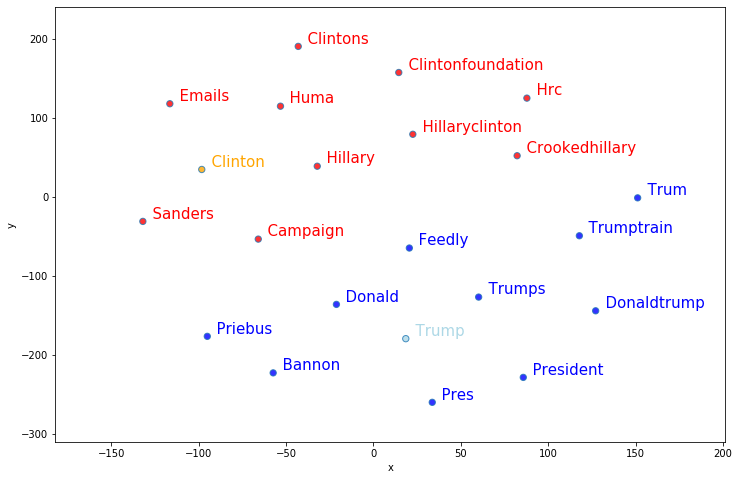

In [300]:
plot_word_embeddings("clinton", "trump", n_comparison =10, w2v_model =  w2v_skip10)

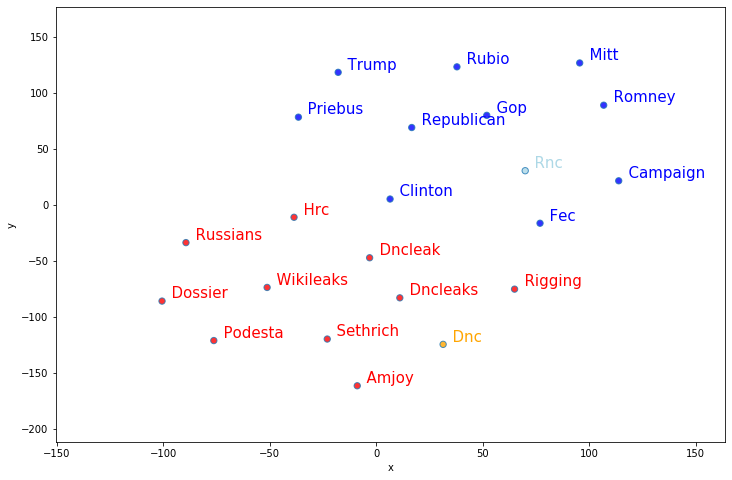

In [301]:
plot_word_embeddings("dnc", "rnc", n_comparison =10, w2v_model =  w2v_skip10)

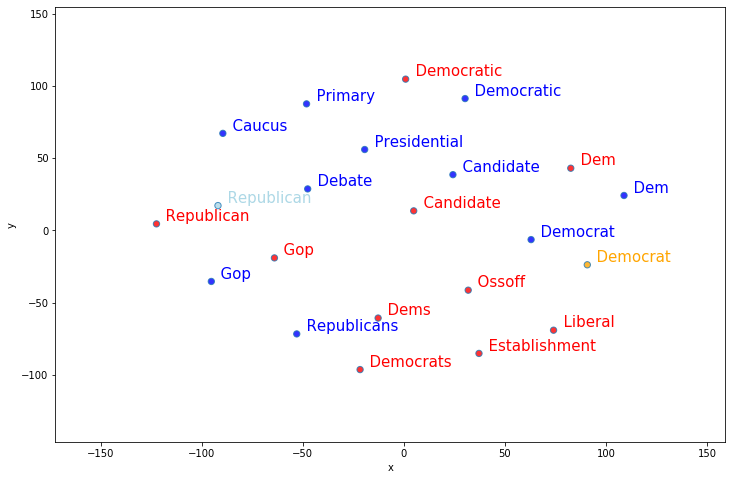

In [303]:
plot_word_embeddings("democrat", "republican", n_comparison =10, w2v_model =  w2v_skip10)

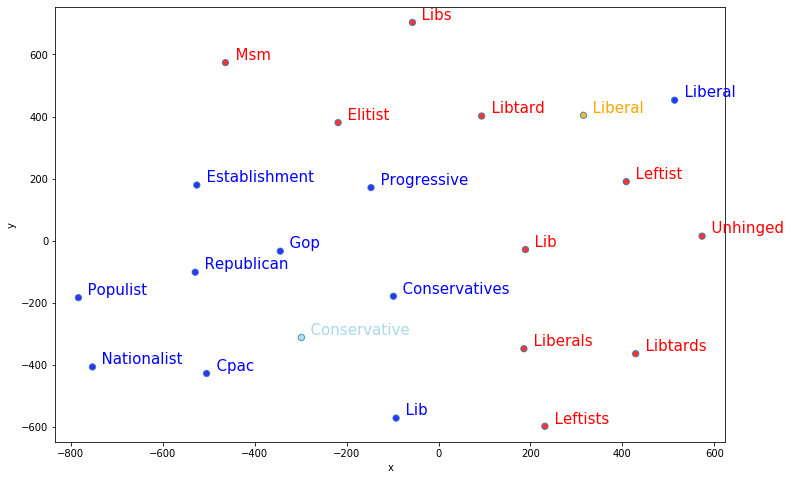

In [304]:
plot_word_embeddings("liberal", "conservative", n_comparison =10, w2v_model =  w2v_skip10)

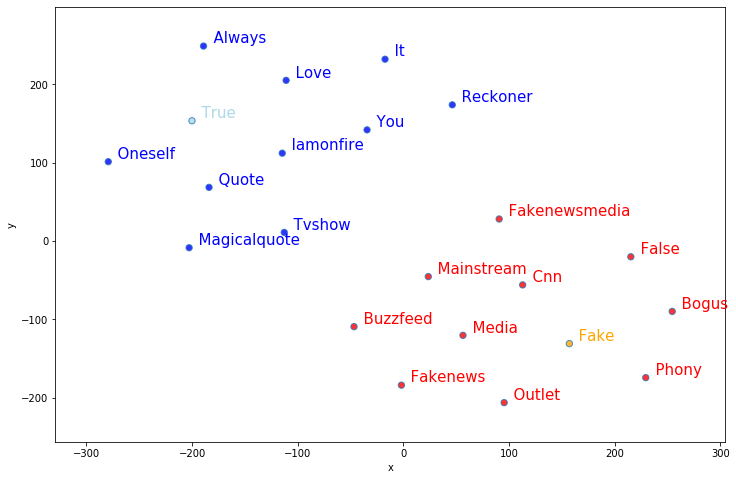

In [307]:
plot_word_embeddings("fake", "true", n_comparison =10, w2v_model =  w2v_skip10)

These visualizationsare awesome! We can clearly see how these tweets tried to generate negative connotations for certain words.

More stuff to visualize later:
- LGBT
- BlackLivesMatter
- Racism
- Taxes
- Immigration
- etc...